# **Libs**

In [1]:
pip install contextily

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install osmnx

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install ortools

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install folium

Note: you may need to restart the kernel to use updated packages.


# **1st Stage**

In [183]:
import collections
collections.Iterable = collections.abc.Iterable

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import itertools

from ortools.constraint_solver import pywrapcp
from ortools.constraint_solver import routing_enums_pb2

In [184]:
# Import necessary packages
import contextily as ctx
import folium
import geopy.distance
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
from operator import itemgetter
from ortools.constraint_solver import pywrapcp
from ortools.constraint_solver import routing_enums_pb2

In [185]:
# customer count ('0' is depot)
customer_count = 20

# the number of vehicle
vehicle_count = 4

# the capacity of vehicle
vehicle_capacity = 50

# fix random seed
np.random.seed(seed=277)

# set depot latitude and longitude
# South Tangerang
depot_latitude = -6.2741
depot_longitude = 106.7206
# New York
# depot_latitude = 40.748817
# depot_longitude = -73.985428

# make dataframe which contains vending machine location and demand
df = pd.DataFrame({"latitude":np.random.normal(depot_latitude, 0.007, customer_count),
                   "longitude":np.random.normal(depot_longitude, 0.007, customer_count),
                   "demand":np.random.randint(1, 10, customer_count)})

df.loc[0, 'latitude'] = depot_latitude
df.loc[0, 'longitude'] = depot_longitude
df.loc[0, 'demand'] = 0

In [186]:
df

,latitude,longitude,demand
0,-6.274100,106.720600,0
1,-6.275384,106.721725,6
2,-6.272985,106.723493,4
3,-6.277322,106.727716,7
4,-6.269740,106.722429,6
5,-6.280665,106.725164,4
6,-6.269903,106.715015,4
7,-6.266759,106.713001,5
8,-6.275723,106.728241,3
9,-6.258991,106.722276,9


In [187]:
CENTER_LOCATION = (df['latitude'].iloc[0], df['longitude'].iloc[0])

In [188]:
DIST = 3000

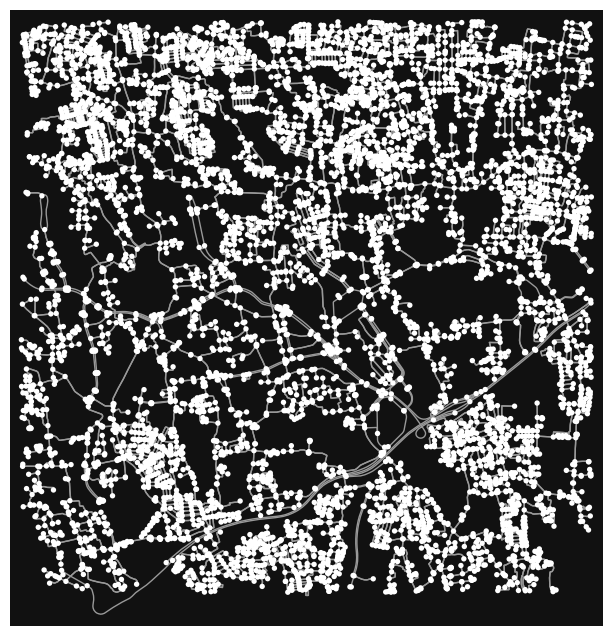

In [189]:
# Get the highway graph
G = ox.graph_from_point(CENTER_LOCATION, dist=DIST, network_type='drive')
*_, = ox.plot_graph(G)

In [190]:
G = ox.utils_graph.get_largest_component(G, strongly=True)

In [191]:
ox.distance.add_edge_lengths(G)

In [192]:
# Create map object
m = folium.Map(location=CENTER_LOCATION, zoom_start=16)

In [193]:
df

,latitude,longitude,demand
0,-6.274100,106.720600,0
1,-6.275384,106.721725,6
2,-6.272985,106.723493,4
3,-6.277322,106.727716,7
4,-6.269740,106.722429,6
5,-6.280665,106.725164,4
6,-6.269903,106.715015,4
7,-6.266759,106.713001,5
8,-6.275723,106.728241,3
9,-6.258991,106.722276,9


In [194]:
for i in range(len(df)):
    stop_coords = (df['latitude'].iloc[i], df['longitude'].iloc[i])
    folium.Marker(location=stop_coords, icon=folium.Icon(color='green', icon='bus', prefix='fa'), tooltip=f"Bus Stop {stop_coords}").add_to(m)

In [195]:
m

In [196]:
depot = ox.distance.nearest_nodes(G, CENTER_LOCATION[1], CENTER_LOCATION[0])

In [197]:
depot

3658444916

In [198]:
cust_loc = []
for i in range(len(df)-1):
    cust_loc.append(ox.distance.nearest_nodes(G, df['longitude'].iloc[i+1], df['latitude'].iloc[i+1]))

cust_loc

[8495675490,
 10143210227,
 5424222420,
 6325733366,
 5442260974,
 5455438716,
 8794562875,
 10143210222,
 4552359560,
 7061731759,
 5625799424,
 5444502472,
 11399135084,
 5424223533,
 5463551559,
 10143210221,
 5446843293,
 427543628,
 8486848524]

In [199]:
nodes = [depot] + cust_loc
nodes

[3658444916,
 8495675490,
 10143210227,
 5424222420,
 6325733366,
 5442260974,
 5455438716,
 8794562875,
 10143210222,
 4552359560,
 7061731759,
 5625799424,
 5444502472,
 11399135084,
 5424223533,
 5463551559,
 10143210221,
 5446843293,
 427543628,
 8486848524]

In [200]:
def distance_matrix(G,nodes):
    matrix = np.zeros((len(nodes), len(nodes)))
    for i in range(len(nodes)):
        for j in range(len(nodes)):
            matrix[i,j] = nx.shortest_path_length(G, nodes[i], nodes[j],weight='length')
    
    return matrix


In [201]:
dist_mat = distance_matrix(G,nodes)

In [202]:
dist_mat

array([[   0.   ,  968.5  , 1099.196, 1990.749, 1861.782, 1962.533,
        2450.272, 2794.343, 1885.365, 3181.147, 1754.322, 2500.597,
        3814.444, 2598.034, 2276.471, 3321.803, 1897.054, 4102.121,
        1491.521, 2156.704],
       [1237.634,    0.   ,  548.868, 1955.923, 1311.454, 1960.138,
        1558.58 , 2024.954, 1335.037, 2630.819, 1751.927, 2573.99 ,
        3264.116, 2047.706, 2241.645, 3319.408, 1346.726, 3551.793,
         941.193, 2154.309],
       [1714.908, 1610.706,    0.   , 1854.395,  816.854, 2437.412,
        3071.34 , 3345.01 ,  840.437, 2136.219, 2229.201, 3051.264,
        2769.516, 1553.106, 2140.117, 3796.682,  852.126, 3057.193,
         446.593, 2631.583],
       [1665.669, 1561.467, 1002.021,    0.   , 1764.607, 2388.173,
        3022.101, 3295.771,  793.579, 3083.972, 2179.962, 3002.025,
        3717.269, 2500.859,  667.003, 3747.443,  805.268, 4004.946,
        1394.346, 2582.344],
       [2176.516, 2072.314, 1512.868, 2316.003,    0.   , 2899.02 ,


In [203]:
data = {}
data["distance_matrix"] = dist_mat.astype(int)
data["demands"] = list(df.demand)
data["vehicle_capacity"] = [25,25,25,25]
data["num_vehicles"] = 4
data["depot"] = 0

In [204]:
manager = pywrapcp.RoutingIndexManager(
        len(data["distance_matrix"]), data["num_vehicles"], data["depot"]
    )

In [205]:
routing = pywrapcp.RoutingModel(manager)

In [206]:
def distance_callback(from_index, to_index):
        """Returns the distance between the two nodes."""
        # Convert from routing variable Index to distance matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data["distance_matrix"][from_node][to_node]

In [207]:
transit_callback_index = routing.RegisterTransitCallback(distance_callback)

In [208]:
routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

In [209]:
# Add Capacity constraint.
def demand_callback(from_index):
    """Returns the demand of the node."""
    # Convert from routing variable Index to demands NodeIndex.
    from_node = manager.IndexToNode(from_index)
    return data["demands"][from_node]

In [210]:
demand_callback_index = routing.RegisterUnaryTransitCallback(demand_callback)
routing.AddDimensionWithVehicleCapacity(
        demand_callback_index,
        0,  # null capacity slack
        data["vehicle_capacity"],  # vehicle maximum capacities
        False,  # start cumul to zero
        "Capacity",
)

True

In [211]:
dimension_name = 'Distance'
routing.AddDimension(
    transit_callback_index,
    0,  # no slack
    20000,  # vehicle maximum travel distance
    False,  # start cumul to zero
    dimension_name
)

True

In [212]:
def print_solution(data, manager, routing, solution):
    """Prints solution on console."""
    print(f"Objective: {solution.ObjectiveValue()}")
    total_distance = 0
    total_load = 0
    route = {}
    for vehicle_id in range(data["num_vehicles"]):
        route[vehicle_id] = []
        index = routing.Start(vehicle_id)
        plan_output = f"Route for vehicle {vehicle_id}:\n"
        route_distance = 0
        route_load = 0
        while not routing.IsEnd(index):
            node_index = manager.IndexToNode(index)
            route_load += data["demands"][node_index]
            plan_output += f" {node_index} Load({route_load}) -> "
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id
            )
            route[vehicle_id].append(node_index)
        route[vehicle_id].append(0)
        plan_output += f" {manager.IndexToNode(index)} Load({route_load})\n"
        plan_output += f"Distance of the route: {route_distance}m\n"
        plan_output += f"Load of the route: {route_load}"
        print(plan_output)
        print("max load: ",data["vehicle_capacity"][vehicle_id],"\n")
        total_distance += route_distance
        total_load += route_load
    print(f"Total distance of all routes: {total_distance}m")
    print(f"Total load of all routes: {total_load}")

    return route

In [213]:
# Setting first solution heuristic.
search_parameters = pywrapcp.DefaultRoutingSearchParameters()
search_parameters.first_solution_strategy = (
    routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
)
search_parameters.local_search_metaheuristic = (
    routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH
)
search_parameters.time_limit.FromSeconds(1)

# Solve the problem.
solution = routing.SolveWithParameters(search_parameters)

# Print solution on console.
if solution:
    route = print_solution(data, manager, routing, solution)

Objective: 38434
Route for vehicle 0:
 0 Load(0) ->  15 Load(3) ->  9 Load(12) ->  17 Load(16) ->  7 Load(21) ->  6 Load(25) ->  0 Load(25)
Distance of the route: 14227m
Load of the route: 25
max load:  25 

Route for vehicle 1:
 0 Load(0) ->  4 Load(6) ->  16 Load(14) ->  14 Load(18) ->  3 Load(25) ->  0 Load(25)
Distance of the route: 6816m
Load of the route: 25
max load:  25 

Route for vehicle 2:
 0 Load(0) ->  1 Load(6) ->  5 Load(10) ->  19 Load(15) ->  10 Load(24) ->  11 Load(25) ->  0 Load(25)
Distance of the route: 8086m
Load of the route: 25
max load:  25 

Route for vehicle 3:
 0 Load(0) ->  2 Load(4) ->  12 Load(10) ->  13 Load(17) ->  18 Load(22) ->  8 Load(25) ->  0 Load(25)
Distance of the route: 9305m
Load of the route: 25
max load:  25 

Total distance of all routes: 38434m
Total load of all routes: 100


In [214]:
route_clean = route.copy()
keys_to_delete = []
for key, value in route_clean.items():
    if value == [0, 0]:
        keys_to_delete.append(key)

for key in keys_to_delete:
    del route_clean[key]
route_clean

{0: [0, 15, 9, 17, 7, 6, 0],
 1: [0, 4, 16, 14, 3, 0],
 2: [0, 1, 5, 19, 10, 11, 0],
 3: [0, 2, 12, 13, 18, 8, 0]}

In [215]:
# Create map object
m = folium.Map(location=CENTER_LOCATION, zoom_start=16)

# # Plot depot
# depot_coords = (G.nodes[depot]['y'], G.nodes[depot]['x'])
# folium.Marker(location=depot_coords, icon=folium.Icon(color='red', icon='home', prefix='fa'), tooltip=f"Depot {depot_coords}").add_to(m)

# Plot bus stops
for i in range(len(df)):
    if i == 0:
        stop_coords = (df['latitude'].iloc[i], df['longitude'].iloc[i])
        folium.Marker(location=stop_coords, icon=folium.Icon(color='red', icon='home', prefix='fa'), tooltip=f"Depot {i}").add_to(m)
    else:
        stop_coords = (df['latitude'].iloc[i], df['longitude'].iloc[i])
        folium.Marker(location=stop_coords, icon=folium.Icon(color='red', icon='bus', prefix='fa'), tooltip=f"Node {i}").add_to(m)        

# Create colors for routes
colors = ['blue', 'orange', 'purple', 'green']

# Plot routes
for vehicle_id in range(4):
    index = routing.Start(vehicle_id)
    route = []
    while not routing.IsEnd(index):
        node_index = manager.IndexToNode(index)
        route.append(nodes[node_index])
        index = solution.Value(routing.NextVar(index))
    route.append(nodes[manager.IndexToNode(index)])
    color = colors[vehicle_id % 4]
    # Create a list of line segments for the route
    segments = []
    for i in range(len(route)-1):
        # Get shortest path between nodes
        path = nx.shortest_path(G, route[i], route[i + 1], weight='length')
        # Add line segment to list
        segments.append([(G.nodes[node]['y'], G.nodes[node]['x']) for node in path])
    # Create polyline from line segments and add to map
    for segment in segments:
        folium.PolyLine(locations=segment, color=color, weight=5).add_to(m)

# Display map
m

# **2nd Stage**

In [216]:
route_clean

{0: [0, 15, 9, 17, 7, 6, 0],
 1: [0, 4, 16, 14, 3, 0],
 2: [0, 1, 5, 19, 10, 11, 0],
 3: [0, 2, 12, 13, 18, 8, 0]}

In [217]:
route_clean_new = route_clean.copy()

In [218]:
perc = 0.3
remove_node0 = []
for key in list(route_clean_new.keys()):
  route_clean_new[key] = route_clean[key][round(len(route_clean[key])*perc):]
  remove_node0.append(route_clean[key][1:round(len(route_clean[key])*perc)])

remove_node = []
[remove_node.extend(sublist) for sublist in remove_node0]

route_clean_new

{0: [9, 17, 7, 6, 0],
 1: [16, 14, 3, 0],
 2: [5, 19, 10, 11, 0],
 3: [12, 13, 18, 8, 0]}

In [219]:
remove_node

[15, 4, 1, 2]

In [220]:
df2 = pd.DataFrame({"latitude":np.random.normal(depot_latitude, 0.007, customer_count),
                   "longitude":np.random.normal(depot_longitude, 0.007, customer_count),
                   "demand":np.random.randint(1, 10, customer_count)})

In [221]:
df_new = pd.concat([df, df2], axis=0,ignore_index=True)

In [222]:
df_new

,latitude,longitude,demand
0,-6.274100,106.720600,0
1,-6.275384,106.721725,6
2,-6.272985,106.723493,4
3,-6.277322,106.727716,7
4,-6.269740,106.722429,6
5,-6.280665,106.725164,4
6,-6.269903,106.715015,4
7,-6.266759,106.713001,5
8,-6.275723,106.728241,3
9,-6.258991,106.722276,9


In [223]:
for i in range(len(df_new)):
    stop_coords = (df_new['latitude'].iloc[i], df_new['longitude'].iloc[i])
    folium.Marker(location=stop_coords, icon=folium.Icon(color='green', icon='bus', prefix='fa'), tooltip=f"Bus Stop {stop_coords}").add_to(m)

In [224]:
m

In [225]:
depot = ox.distance.nearest_nodes(G, CENTER_LOCATION[1], CENTER_LOCATION[0])

cust_loc = []
for i in range(len(df_new)-1):
    cust_loc.append(ox.distance.nearest_nodes(G, df_new['longitude'].iloc[i+1], df_new['latitude'].iloc[i+1]))

In [226]:
nodes = [depot] + cust_loc

In [227]:
dist_mat = distance_matrix(G,nodes)

In [228]:
data_new = {}
data_new["distance_matrix"] = dist_mat.astype(int)
data_new["demands"] = list(df_new.demand)
data_new["num_vehicles"] = 4
data_new["depot"] = 0
data_new["vehicle_capacity"] = [250,250,250,250]
data_new['starts'] = []
data_new['ends'] = []
for key in list(route_clean_new.keys()):
  data_new['starts'].append(route_clean_new[key][0])
  data_new['ends'].append(0)
data_new

{'distance_matrix': array([[   0,  968, 1099, ..., 1939, 2206, 1529],
        [1237,    0,  548, ..., 1389, 1655, 1527],
        [1714, 1610,    0, ...,  894, 1161, 2004],
        ...,
        [2308, 2204, 1644, ...,    0,  428, 2597],
        [2574, 2470, 1910, ...,  428,    0, 2863],
        [1597, 1495, 1625, ..., 2466, 2732,    0]]),
 'demands': [0,
  6,
  4,
  7,
  6,
  4,
  4,
  5,
  3,
  9,
  9,
  1,
  6,
  7,
  4,
  3,
  8,
  4,
  5,
  5,
  1,
  9,
  4,
  8,
  1,
  6,
  2,
  6,
  2,
  7,
  2,
  6,
  3,
  3,
  2,
  4,
  5,
  5,
  6,
  4],
 'num_vehicles': 4,
 'depot': 0,
 'vehicle_capacity': [250, 250, 250, 250],
 'starts': [9, 16, 5, 12],
 'ends': [0, 0, 0, 0]}

In [229]:
for node in remove_node:
  data_new['demands'][node] = 1000000

In [230]:
manager = pywrapcp.RoutingIndexManager(
        len(data_new["distance_matrix"]), data_new["num_vehicles"], data_new["starts"], data_new["ends"]
    )

In [231]:
routing = pywrapcp.RoutingModel(manager)

In [232]:
# avoiding nodes that already visited
penalty = 100000000000
for node in remove_node:
    routing.AddDisjunction([manager.NodeToIndex(node)], penalty)

In [233]:
def distance_callback(from_index, to_index):
        """Returns the distance between the two nodes."""
        # Convert from routing variable Index to distance matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data_new["distance_matrix"][from_node][to_node]
transit_callback_index = routing.RegisterTransitCallback(distance_callback)

routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

In [234]:
# vehicle k must visit node i
for key in list(route_clean_new.keys()):
  for idx in route_clean_new[key][:-1]:
    routing.SetAllowedVehiclesForIndex([key], manager.NodeToIndex(idx))

In [235]:
dimension_name = 'Distance'
routing.AddDimension(
    transit_callback_index,
    0,  # no slack
    18000,  # vehicle maximum travel distance
    False,  # start cumul to zero
    dimension_name
)

True

In [236]:
# Add Capacity constraint.
def demand_callback(from_index):
    """Returns the demand of the node."""
    # Convert from routing variable Index to demands NodeIndex.
    from_node = manager.IndexToNode(from_index)
    return data_new["demands"][from_node]

demand_callback_index = routing.RegisterUnaryTransitCallback(demand_callback)
routing.AddDimensionWithVehicleCapacity(
        demand_callback_index,
        0,  # null capacity slack
        data_new["vehicle_capacity"],  # vehicle maximum capacities
        False,  # start cumul to zero
        "Capacity",
)

True

In [237]:
def print_solution2(data, manager, routing, solution):
    """Prints solution on console."""
    print(f"Objective: {solution.ObjectiveValue()}")
    total_distance = 0
    #total_load = 0
    route = {}
    for vehicle_id in range(data["num_vehicles"]):
        route[vehicle_id] = []
        index = routing.Start(vehicle_id)
        plan_output = f"Route for vehicle {vehicle_id}:\n"
        route_distance = 0
        #route_load = 0
        while not routing.IsEnd(index):
            node_index = manager.IndexToNode(index)
            #route_load += data["demands"][node_index]
            plan_output += f" {node_index} -> "
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id
            )
            route[vehicle_id].append(node_index)
        route[vehicle_id].append(0)
        plan_output += f" {manager.IndexToNode(index)}\n"
        plan_output += f"Distance of the route: {route_distance}m\n"
        #plan_output += f"Load of the route: {route_load}"
        print(plan_output)
        #print("max load: ",data["vehicle_capacity"][vehicle_id],"\n")
        total_distance += route_distance
        #total_load += route_load
    print(f"Total distance of all routes: {total_distance}m")
    #print(f"Total load of all routes: {total_load}")

    return route

In [238]:
# Setting first solution heuristic.
search_parameters = pywrapcp.DefaultRoutingSearchParameters()
search_parameters.first_solution_strategy = (
    routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
)
search_parameters.local_search_metaheuristic = (
    routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH
)
search_parameters.time_limit.FromSeconds(1)

# Solve the problem.
solution = routing.SolveWithParameters(search_parameters)

# Print solution on console.
if solution:
    route = print_solution2(data_new, manager, routing, solution)

Objective: 400000033810
Route for vehicle 0:
 9 ->  17 ->  33 ->  22 ->  7 ->  6 ->  28 ->  0
Distance of the route: 7386m

Route for vehicle 1:
 16 ->  14 ->  3 ->  38 ->  37 ->  32 ->  34 ->  25 ->  35 ->  27 ->  0
Distance of the route: 10121m

Route for vehicle 2:
 5 ->  20 ->  19 ->  39 ->  21 ->  23 ->  10 ->  29 ->  11 ->  0
Distance of the route: 6285m

Route for vehicle 3:
 12 ->  13 ->  31 ->  24 ->  30 ->  18 ->  8 ->  26 ->  36 ->  0
Distance of the route: 10018m

Total distance of all routes: 33810m


In [239]:
route_clean = route.copy()
keys_to_delete = []
for key, value in route_clean.items():
    if value == [0, 0]:
        keys_to_delete.append(key)

for key in keys_to_delete:
    del route_clean[key]
route_clean

{0: [9, 17, 33, 22, 7, 6, 28, 0],
 1: [16, 14, 3, 38, 37, 32, 34, 25, 35, 27, 0],
 2: [5, 20, 19, 39, 21, 23, 10, 29, 11, 0],
 3: [12, 13, 31, 24, 30, 18, 8, 26, 36, 0]}

In [240]:
# Create map object
m = folium.Map(location=CENTER_LOCATION, zoom_start=16)

# # Plot depot
# depot_coords = (G.nodes[depot]['y'], G.nodes[depot]['x'])
# folium.Marker(location=depot_coords, icon=folium.Icon(color='red', icon='home', prefix='fa'), tooltip=f"Depot {depot_coords}").add_to(m)

# Plot bus stops
for i in range(len(df_new)):
    if i == 0:
        stop_coords = (df_new['latitude'].iloc[i], df_new['longitude'].iloc[i])
        folium.Marker(location=stop_coords, icon=folium.Icon(color='red', icon='home', prefix='fa'), tooltip=f"Depot {i}").add_to(m)
    else:
        stop_coords = (df_new['latitude'].iloc[i], df_new['longitude'].iloc[i])
        folium.Marker(location=stop_coords, icon=folium.Icon(color='red', icon='bus', prefix='fa'), tooltip=f"Node {i}").add_to(m)        

# Create colors for routes
colors = ['blue', 'orange', 'purple', 'green']

# Plot routes
for vehicle_id in range(4):
    index = routing.Start(vehicle_id)
    route = []
    while not routing.IsEnd(index):
        node_index = manager.IndexToNode(index)
        route.append(nodes[node_index])
        index = solution.Value(routing.NextVar(index))
    route.append(nodes[manager.IndexToNode(index)])
    color = colors[vehicle_id % 4]
    # Create a list of line segments for the route
    segments = []
    for i in range(len(route)-1):
        # Get shortest path between nodes
        path = nx.shortest_path(G, route[i], route[i + 1], weight='length')
        # Add line segment to list
        segments.append([(G.nodes[node]['y'], G.nodes[node]['x']) for node in path])
    # Create polyline from line segments and add to map
    for segment in segments:
        folium.PolyLine(locations=segment, color=color, weight=5).add_to(m)

# Display map
m

In [241]:
remove_node

[15, 4, 1, 2]